# Bayesian Judging
### Eric Miller, Olin College

Election theory is a mature field concerned with the question of how to pick the best of several options given a large number of contradictory votes, where each voter is generally assumed to be familiar with most or all of the available options. This article analyzes a related but subtly different problem of picking the best of *very many* options, where the number of candidates is sufficiently large that no single "voter" can be expected to have knowledge of all of them.

One common application where this problem arises is in expo judging at hackathons, where each submitted proejct is a "candidate" to win, and each judge only has time to judge (typically) five to 10 projects. As a result, a statistical problem arises in how to combine the information from the different judges into a single ranking, while accounting for the uncertainty inherent in the judges' opinions. 

## Collecting information

The first question that arises is what information to collect from each judge about each project they look at. The most obvious and common answer is to have each judge rate each project they see on some scale (for example, 1-10). Unfortunately, this approach has a few fundamental problems.

- Every judge will have different expectations about what rating to give each project, making it hard to combine their votes in a fair way
- Within a single judge, their rating scale may change during the day as they are exposed to more projects and get a better sense for what "normal" means
- Rating scales often have poor discriminatory power near the extremes. If the goal is to hand out a single first-place trophy, it is a problem if multiple teams have very similar or identical ratings

An alternative procedure is to instead ask judges to perform *pairwise comparisons*, an approach pioneered by the the [Gavel](https://github.com/anishathalye/gavel) expo judging system at HackMIT and the [CrowdBT paper](http://people.stern.nyu.edu/xchen3/images/crowd_pairwise.pdf) from Microsoft Research. In this system, judges are asked to look at two projects, then simply vote on which of the two is *better*. This removes the need to calibrate judges against each other, and aligns with a body of psychological research indicating that humans are quite good a performing pairwise comparisons.

This article is heavily based on a series of 
[blog](https://www.anishathalye.com/2015/03/07/designing-a-better-judging-system/) 
[posts](https://www.anishathalye.com/2015/11/09/implementing-a-scalable-judging-system/) explaining the Gavel system, but takes a Bayesian approach to analyzing the data using PyMC3.

## Analysis problem

Once the data has been collected, the problem remains of aggregating all of the pairwise comparisons into a global estimate of which team is truly best. We treat this a the problem of estimating a series of parameters $\Beta_i$ which represents the true quality of Team $i$'s submission, and a series of parameters $p_x$ which relate to the reliability of judge $x$. We do this by first building a forward model for the likelihood of a given judging result, then applying Bayesian methods using PyMC3 to create a posterior joint distribution over these parameters.

<img width="50%" src="https://www.anishathalye.com/media/2015/03/07/adjacency-graph.png"/>

In [4]:
import numpy as np
import itertools

import pandas as pd
import pymc3 as pm
from pymc3.math import exp, sqrt
from thinkbayes2 import Pmf, Cdf, Suite, Joint, MakeJoint, MakeMixture, MakeNormalPmf, Beta
import thinkplot

# Modelling Teams and Judges

We use Python objects to store the PyMC objects associated with each team and judge.

We start with the assumption that the average judge is better-than-chance at picking good teams to force the optimization to converge to the correct minima.

In [110]:
class Tournament(object):
    def __init__(self, name='globals'):
        self.name = name
        
        # Standard deviation of team quality
        self.team_sd = pm.HalfNormal(f"{self.name}_team_sd", 5) 
        
        # Mean and standard deviation of judge reliability
        self.judge_mu = 0.75
        self.judge_sd = 0.1
        
class Team(object):
    _counter = 0
    
    def __init__(self, tournament, name=None):
        if name is None:
            name = f"t{Team._counter}"
            Team._counter += 1
        self.name = name
        
        self.tournament = tournament
        
        self.quality = pm.Normal(f"{self.name}_quality", mu=0, sd=tournament.team_sd)
        
    def __str__(self):
        return f"Team {self.name}"
        
class Judge(object):
    _counter = 0
    
    def __init__(self, tournament, name=None):
        if name is None:
            name = f"j{Judge._counter}"
            Judge._counter += 1
        self.name = name
        
        self.tournament = tournament
        
        self.reliability = pm.Beta(f"{self.name}_reliability", mu=tournament.judge_mu, sd=tournament.judge_sd)
        
    def __str__(self):
        return f"Judge {self.name}"

# Forward model of results

In a classical Bradley-Terry model, each team is represented by a single number $\beta_i$ where the probability that a judge ranks $i>j$ is 

$$P(i > j) = \frac{e^{\beta_i}}{e^{\beta_i} + e^{\beta_j}}$$

[source](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model)

This model treats all judges as being identical, which is not an accurate assumption in an expo environment, so we extend this model with an extra term $p_x$ for each judge, representing the probability that this specific judge will "tell the truth" about a comparison they are assessing.

$$P(i > j | x) = p_x * \frac{e^{\beta_i}}{e^{\beta_i} + e^{\beta_j}} + (1-p_x) * \frac{e^{\beta_j}}{e^{\beta_i} + e^{\beta_j}}$$

In [111]:
class JudgingResult(object):
    _counter = 0
    
    def __init__(self, tournament, winner, loser, judge, name=None):
        if name is None:
            name = f"j{Judge._counter}"
            Judge._counter += 1
        self.name = name
        
        p_bt = exp(winner.quality) / (exp(loser.quality)+exp(winner.quality))
        self.result = pm.Binomial(f'judging_result_{name}', n=1, 
                    p=judge.reliability * p_bt + (1-judge.reliability) * (1-p_bt), observed=1)
    
    def __str__(self):
        return f"Result {self.name}"

## Trivial example using MCMC

To test the validity of these functions, we create a sample tournament with just two teams, where a single judge assesses team 1 to be better than team 0.

In [120]:
with pm.Model() as model:
    tournament = Tournament()
    teams = {}
    for i in range(2):
        teams[i] = Team(tournament, str(i))
    
    judges = {}
    for i in range(1):
        judges[i] = Judge(tournament, str(i))

    result = JudgingResult(tournament, teams[1], teams[0], judges[0])

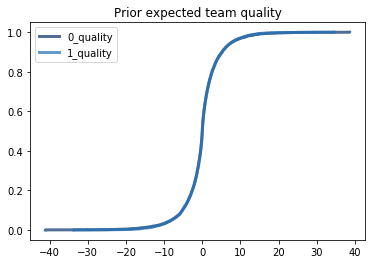

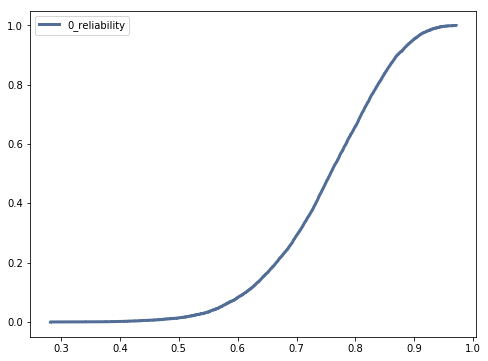

Team 1 wins 50.45% of rematches


<Figure size 576x432 with 0 Axes>

In [113]:
## Inspect prior
with model:
    trace_prior = pm.sample_prior_predictive(10000)

for _, team in teams.items():
    thinkplot.Cdf(Cdf(trace_prior[team.quality.name]), label=team.quality.name)
thinkplot.Config(title="Prior expected team quality")
thinkplot.Show()

for i, judge in judges.items():
    thinkplot.Cdf(Cdf(trace_prior[judge.reliability.name]), label=judge.reliability.name)
thinkplot.Config()
thinkplot.Show()

print(f"Team 1 wins {100*np.mean(trace_prior[result.result.name] == 1):.2f}% of rematches")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [0_reliability, 1_quality, 0_quality, globals_team_sd]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:07<00:00, 1083.55draws/s]
There were 175 divergences after tuning. Increase `target_accept` or reparameterize.
There were 172 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


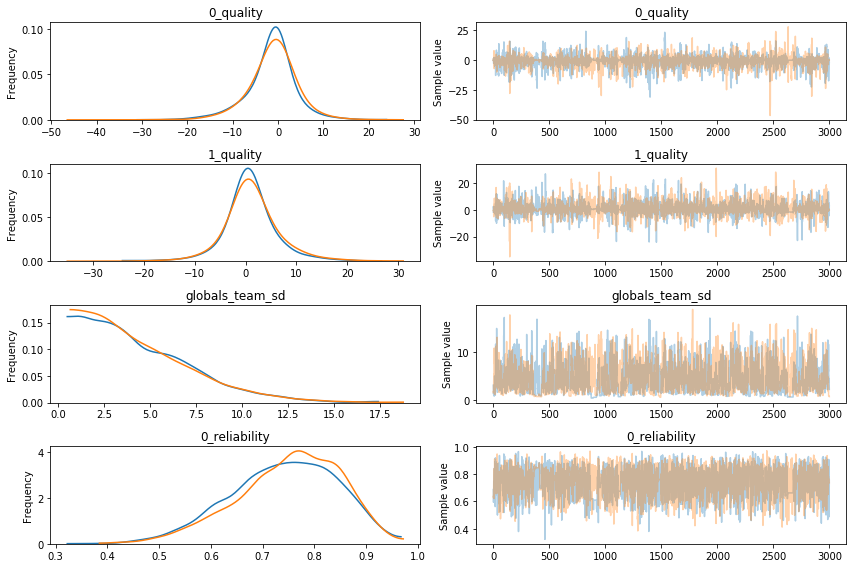

In [115]:
## Compute posterior

with model:
    trace = pm.sample(3000, tune=1000)
    
pm.traceplot(trace);

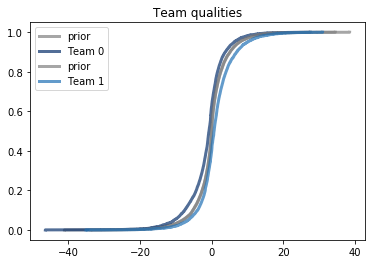

Team 1 is better with confidence 68.1%


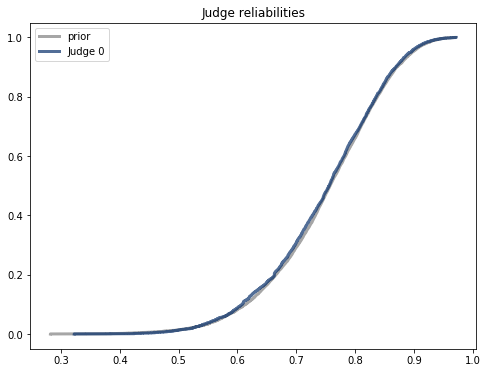

<Figure size 576x432 with 0 Axes>

In [126]:
for i, team in teams.items():
    thinkplot.Cdf(Cdf(trace_prior[team.quality.name]), label='prior', color='grey')
    
    thinkplot.Cdf(Cdf(trace[team.quality.name]), label=str(team))
    
    thinkplot.Config(title='Team qualities')
    
thinkplot.Show()

print(f"Team 1 is better with confidence \
{100*np.mean(trace[teams[1].quality.name] > trace[teams[0].quality.name]):.1f}%")

for i, judge in judges.items():
    thinkplot.Cdf(Cdf(trace_prior[judge.reliability.name]), label='prior', color='grey')
    
    thinkplot.Cdf(Cdf(trace[judge.reliability.name]), label=str(judge))
    
    thinkplot.Config(title="Judge reliabilities")
    

thinkplot.Show()

This behaves exactly as expected, with the rating pushing Team 1's score slightly higher, but having no effect on our assessment of the judge's reliability because there are no other judges to compare them against.

# Extending to real data

HackMIT has actually published the full set of data from the 2015 HackMIT judging session. Now, we will load that data, and attempt to extract from it which team deserves to win.

This dataset contains approximately 1400 votes.

In [136]:
data = list(pd.read_csv('../data/blueprint-rookie-data.csv').itertuples())[:30]  # ~240 votes
# data = list(pd.read_csv('../data/judging-data-hackmit.csv').itertuples())  # ~1400 votes

In [140]:
def make_model(data):
    """
    data is a list of named tuples containing "annotator", "loser", and "winner" elements
    """
    with pm.Model() as model:
        tournament = Tournament()
        
        teams = {}
        for i in set((r.winner for r in data)).union(set((r.loser for r in data))):
            teams[i] = Team(tournament, i)

        judges = {}
        for i in set((r.annotator for r in data)):
            judges[i] = Judge(tournament, i)

        for i, r in enumerate(data):
            JudgingResult(tournament, teams[r.winner], teams[r.loser], judges[r.annotator])
        
    return model, judges, teams

model, judges, teams = make_model(data)

In [ ]:
## Inspect prior
with model:
    trace_prior = pm.sample_prior_predictive(100)

for _, team in teams.items():
    thinkplot.Cdf(Cdf(trace_prior[team.quality.name]), label=team.quality.name)
thinkplot.Config(title="Prior expected team quality")
thinkplot.Show()

for i, judge in judges.items():
    thinkplot.Cdf(Cdfhttp://localhost:8889/notebooks/reports/bayesian-ranking-polished.ipynb#(trace_prior[judge.reliability.name]), label=judge.reliability.name)
thinkplot.Config()
thinkplot.Show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [na_reliability, ffef_quality, 0965_quality, a4ec_quality, 3f1b_quality, dc51_quality, 91b2_quality, bbdd_quality, 0325_quality, 0815_quality, 762c_quality, 2845_quality, fb8d_quality, e212_quality, 17a9_quality, dc8e_quality, 9f2b_quality, da90_quality, c0d7_quality, 70ff_quality, a46f_quality, 26e4_quality, 75f9_quality, 70ef_quality, f717_quality, ecba_quality, 60fb_quality, 1a2a_quality, 945d_quality, b568_quality, globals_team_sd]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:36<00:00, 108.82draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


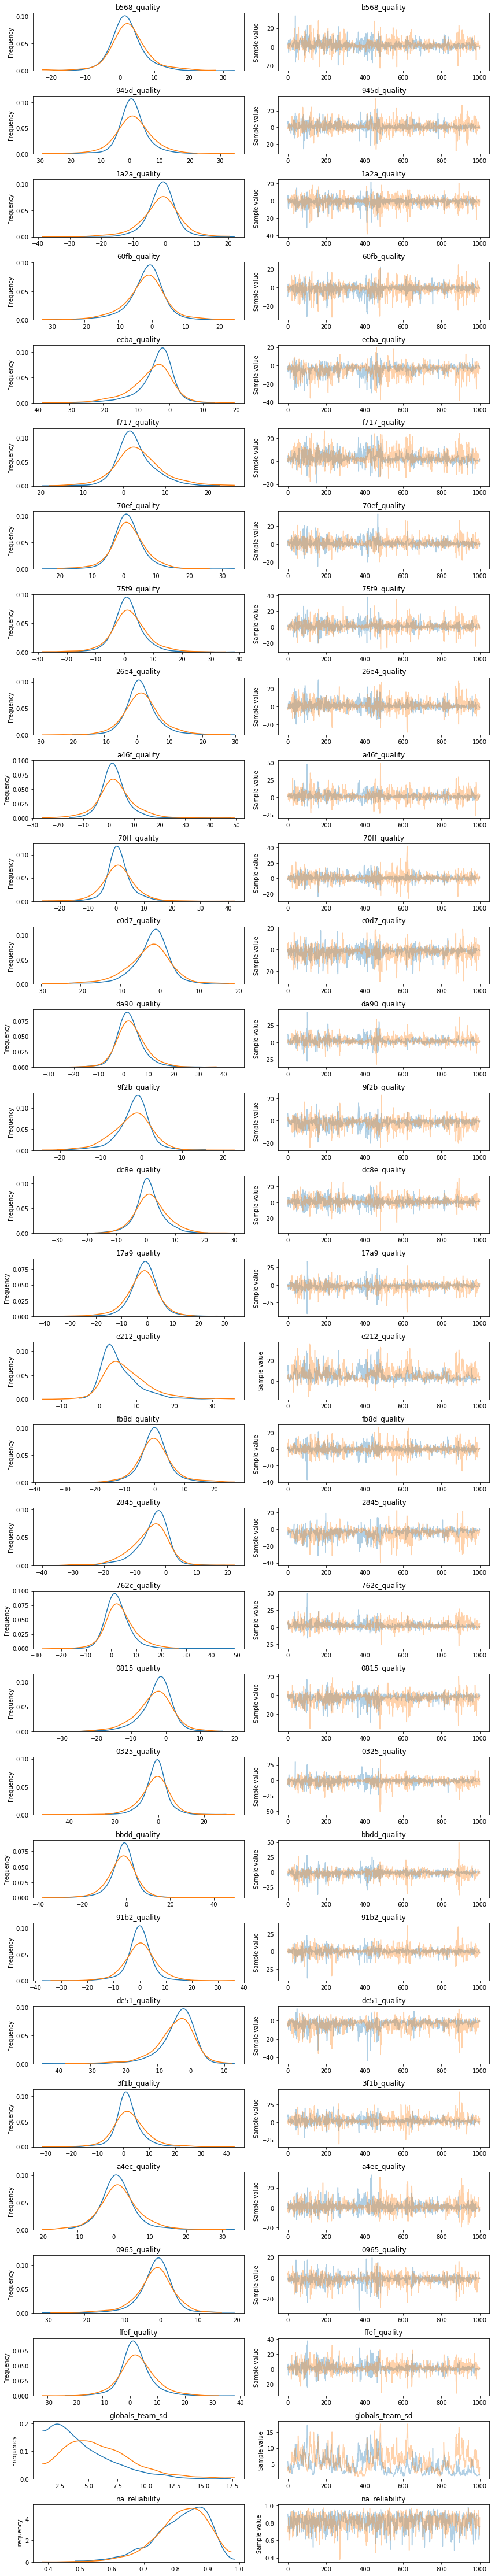

In [141]:
## Compute posterior

with model:
    trace = pm.sample(1000, tune=1000)
    
pm.traceplot(trace);

/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/thinkplot/thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')
/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/thinkplot/thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')
/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/thinkplot/thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')
/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/thinkplot/thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')
/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/thinkplot/thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')


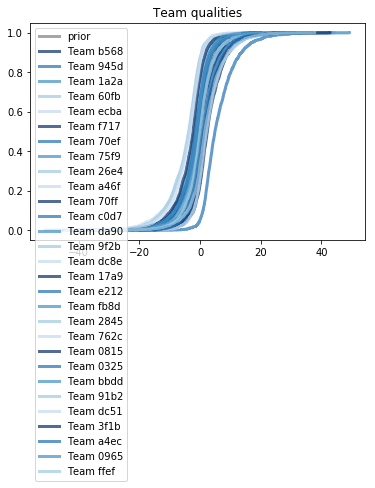

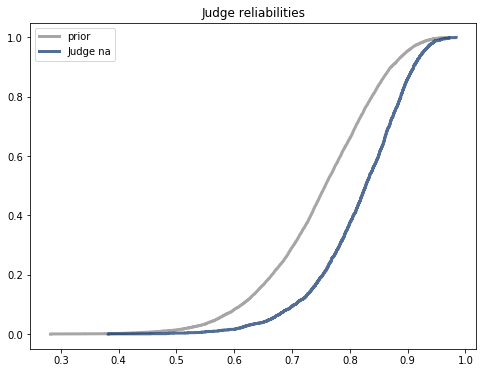

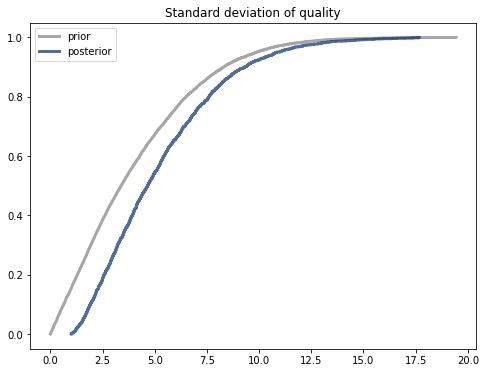

<Figure size 576x432 with 0 Axes>

In [148]:
thinkplot.Cdf(Cdf(trace_prior['0_quality']), label='prior', color='grey')
for i, team in teams.items():    
    thinkplot.Cdf(Cdf(trace[team.quality.name]), label=str(team))
    
    thinkplot.Config(title='Team qualities')
    
thinkplot.Show()

thinkplot.Cdf(Cdf(trace_prior['0_reliability']), label='prior', color='grey')
for i, judge in judges.items():
    
    thinkplot.Cdf(Cdf(trace[judge.reliability.name]), label=str(judge))
    
    thinkplot.Config(title="Judge reliabilities")

thinkplot.Show()


thinkplot.Cdf(Cdf(trace_prior['globals_team_sd']), label='prior', color='grey')

thinkplot.Cdf(Cdf(trace['globals_team_sd']), label='posterior')
    
thinkplot.Config(title="Standard deviation of quality")

thinkplot.Show()

## Analyzing tournament results

Using this trace, we can analyze the results of the tournament to determine which team is the best, and with what probability. Because there exists cross-correlation between the scores of the different teams, we do this by computing the winner separately for each trace in the MCMC output, then count how frequently each team wins.

In [153]:
def compute_winners(trace, teams):
    winners = []
    for i in range(len(trace)):
        winners.append(max(teams, key=lambda team: trace[teams[team].quality.name][i]))
    return winners

winners = compute_winners(trace, teams)

In [155]:
from collections import Counter

for team, count in Counter(winners).most_common():
    # Ignore teams with very few wins
    if count > 5:
        print(f"Team {team} is best with probability {count/len(trace)*100:.1f}%")

Team e212 is best with probability 20.1%
Team f717 is best with probability 7.2%
Team a46f is best with probability 7.0%
Team ffef is best with probability 6.7%
Team 762c is best with probability 6.2%
Team a4ec is best with probability 5.9%
Team 26e4 is best with probability 5.4%
Team 75f9 is best with probability 5.1%
Team dc8e is best with probability 4.7%
Team b568 is best with probability 4.4%
Team 3f1b is best with probability 4.1%
Team da90 is best with probability 4.0%
Team 70ef is best with probability 3.4%
Team 945d is best with probability 3.4%
Team 70ff is best with probability 2.2%
Team bbdd is best with probability 1.7%
Team fb8d is best with probability 1.7%
Team 0325 is best with probability 1.5%
Team 91b2 is best with probability 1.4%
Team 60fb is best with probability 1.2%
Team 17a9 is best with probability 0.9%


This result indicates that, even though one team comes out "on top", **the available judging data is insufficient to demonstrate that they are actually the winner**. To the contrary, this result indicates that there is a 80% chance they are _not_ the best team. 